In [1]:
# Import and Load Config

import sys
sys.path.append(".")

import torch 

from omegaconf import OmegaConf

from dmm.util import instantiate_from_config


def load_model_from_config(config, ckpt):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cpu")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    model.cuda()
    # model.cpu()
    model.eval()
    return model

# Download the ckpt file at: gs://asm-ai-data/Michael/Misc/station.ckpt

def get_model(config, ckpt):
    config = OmegaConf.load(config)  
    model = load_model_from_config(config,ckpt)
    return model

In [3]:
# Load Model and Sampler

# from dmm.models.diffusion.ddim import DDIMSampler
from dmm.models.diffusion.pmls import PLMSSampler

config = "/home/hu/audio-diffusion/configs/cond_1.5.yaml"
ckpt = "/home/hu/audio-diffusion/station.ckpt"
# ckpt = "/home/hu/audio-diffusion/javis_ep39.ckpt"
model = get_model(config, ckpt)
sampler = PLMSSampler(model) # TODO: Modify this for the uncond model

Loading model from /home/hu/audio-diffusion/station.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['visual_projection.weight', 'vision_model.encoder.layers.22.self_attn.out_proj.weight', 'vision_model.encoder.layers.7.self_attn.out_proj.weight', 'vision_model.encoder.layers.0.layer_norm1.bias', 'vision_model.encoder.layers.5.self_attn.out_proj.weight', 'vision_model.encoder.layers.6.mlp.fc2.weight', 'vision_model.encoder.layers.12.self_attn.k_proj.weight', 'vision_model.encoder.layers.23.layer_norm1.bias', 'vision_model.encoder.layers.21.layer_norm1.bias', 'vision_model.encoder.layers.10.self_attn.v_proj.weight', 'vision_model.encoder.layers.3.mlp.fc1.bias', 'vision_model.encoder.layers.12.layer_norm1.weight', 'vision_model.encoder.layers.12.layer_norm2.weight', 'vision_model.encoder.layers.6.mlp.fc1.weight', 'vision_model.encoder.layers.8.mlp.fc2.weight', 'vision_model.encoder.layers.8.self_attn.q_proj.bias', 'vision_model.encoder.layers.16.self_attn.v_proj.weight',

Restored from v1-5-pruned.ckpt with 0 missing and 688 unexpected keys


In [7]:
# Generate Spectrum

import numpy as np 
from PIL import Image
from einops import rearrange
from torchvision.utils import make_grid

n_samples_per_class = 1

ddim_steps = 15
ddim_eta = 0.0


# prompts = ["slow, relax, ambient, sleep"]
prompts = ["hans zimmer"]

uc = model.get_learned_conditioning(n_samples_per_class * [""])
c = model.get_learned_conditioning(prompts)
all_samples = list()

with torch.no_grad():
    with model.ema_scope():
        
        print(f"rendering {n_samples_per_class} examples in {ddim_steps} steps")

        samples_ddim, _ = sampler.sample(S=ddim_steps,
                                            conditioning=c,
                                            batch_size=n_samples_per_class,
                                            shape=[4, 64, 64],
                                            verbose=False,
                                            unconditional_guidance_scale=5, # 3.5
                                            unconditional_conditioning=uc,
                                            eta=ddim_eta)
        x_samples_ddim = model.decode_first_stage(samples_ddim)
        x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0, 
                                        min=0.0, max=1.0)
        all_samples.append(x_samples_ddim)

rendering 1 examples in 15 steps
Data shape for PLMS sampling is (1, 4, 64, 64)
Running PLMS Sampling with 16 timesteps


PLMS Sampler: 100%|██████████| 16/16 [00:03<00:00,  4.93it/s]


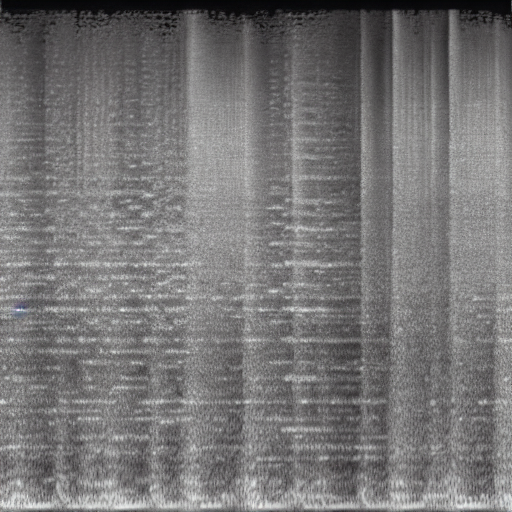

In [8]:
# Plot Spectrum

g = (x_samples_ddim[0] * 255.).cpu().numpy().transpose(1, 2, 0)
Image.fromarray(g.astype(np.uint8))

In [9]:
# Spec to Wav

from IPython.display import Audio
from dmm.util import waveform_from_tensor
aud = waveform_from_tensor(x_samples_ddim[0])
display(Audio(aud, rate=44100))

In [ ]:
# Continuation

import numpy as np 
from PIL import Image
from einops import rearrange
from torchvision.utils import make_grid
import torchaudio

n_samples_per_class = 1

ddim_steps = 15
ddim_eta = 0.0

upload_wav = torchaudio.load("/home/hu/audio-diffusion/prompt.wav")

# prompts = ["slow, relax, ambient, sleep"]
prompts = ["hans zimmer"]

uc = model.get_learned_conditioning(n_samples_per_class * [""])
c = model.get_learned_conditioning(prompts)
all_samples = list()

with torch.no_grad():
    with model.ema_scope():
        
        print(f"rendering {n_samples_per_class} examples in {ddim_steps} steps")

        samples_ddim, _ = sampler.sample(S=ddim_steps,
                                            conditioning=c,
                                            batch_size=n_samples_per_class,
                                            shape=[4, 64, 64],
                                            verbose=False,
                                            unconditional_guidance_scale=5, # 3.5
                                            unconditional_conditioning=uc,
                                            eta=ddim_eta)
        x_samples_ddim = model.decode_first_stage(samples_ddim)
        x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0, 
                                        min=0.0, max=1.0)
        all_samples.append(x_samples_ddim)

In [ ]:
# Load or Upload audio

import torchaudio

wav, sr = torchaudio.load('/home/hu/audio-diffusion/data/EDM/2Elements - Cry For You.mp3')

waveform = torchaudio.transforms.Resample(sr , 44100)(wav)

In [ ]:
# Wav2Mel and Mel2Wav

from dmm.util import waveform_from_spectrogram, spectrogram_from_waveform, image_from_spectrogram, wav_bytes_from_spectrogram_image, waveform_from_tensor

def gray2rgb(x):
    return torch.cat([x, x, x], dim=0)
def get_norm_mel( waveform, _, window_size):
    waveform_slice = waveform[:,:window_size]
    mel = torch.pow(spectrogram_from_waveform(waveform_slice, _, n_fft=16384, hop_length=1024, win_length=4096, n_mels=512) , 0.25)
    mel = (mel/mel.max()).flip(0)
    mel = mel*2.0-1.0
    if torch.isnan(mel).any():
        mel, waveform_slice = get_norm_mel(waveform, _, window_size)
    return mel, waveform_slice

window_size = 1024*512
distribution = model.encode_first_stage(gray2rgb(get_norm_mel(waveform,48000,window_size)[0][...,:512].unsqueeze(0)).unsqueeze(0).cuda())
vector = model.get_first_stage_encoding(distribution)
rec  = model.decode_first_stage(vector)
rec = torch.clamp((rec+1.0)/2.0, min=0.0, max=1.0)
from dmm.util import waveform_from_tensor
aud = waveform_from_tensor(rec[0])
from IPython.display import Audio
display(Audio(aud, rate=44100))

In [1]:
# Inpainting Sample

import numpy as np 
from PIL import Image
from einops import rearrange
from torchvision.utils import make_grid

n_samples_per_class = 1

ddim_steps = 15
ddim_eta = 0.0


# prompts = ["slow, relax, ambient, sleep"]
prompts = ["dance, electric"]

uc = model.get_learned_conditioning(n_samples_per_class * [""])
c = model.get_learned_conditioning(prompts)
all_samples = list()


mask = torch.cat([torch.ones([64,32]),torch.zeros([64,32])],1).repeat(1,4,1,1).cuda()

with torch.no_grad():
    with model.ema_scope():
        
        print(f"rendering {n_samples_per_class} examples in {ddim_steps} steps")

        samples_ddim, _ = sampler.sample(S=ddim_steps,
                                            conditioning=c,
                                            batch_size=n_samples_per_class,
                                            shape=[4, 64, 64],
                                            verbose=False,
                                            unconditional_guidance_scale=7.5, # 3.5
                                            unconditional_conditioning=uc,
                                            x0 = vector.cuda(),
                                            mask = mask,
                                            eta=ddim_eta)
        # samples_ddim = samples_ddim * (1-mask) + vector * mask
        # samples_ddim = vector
        x_samples_ddim = model.decode_first_stage(samples_ddim)
        x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0, 
                                        min=0.0, max=1.0)
        all_samples.append(x_samples_ddim)

from dmm.util import waveform_from_tensor
aud = waveform_from_tensor(x_samples_ddim[0])
from IPython.display import Audio
display(Audio(aud, rate=44100))

NameError: name 'model' is not defined